<a href="https://colab.research.google.com/github/rudra321/CompNeuroProj/blob/main/FINAL_thecoolerneuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####################################################
#
#   Original code by: EBRAINS Lab
#   Modified by group 11: Shreyash, Rudra, Elin
#
####################################################



# IMPORT NECESSARY LIBRARIES

!pip install neuron
from neuron import h, gui, crxd as rxd
from neuron.units import ms, mV
from neuron.crxd.rxdmath import vtrap, exp, log
from neuron.crxd import v
import numpy as np
import matplotlib.pyplot as plt
from math import pi



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 50.9 MB/s eta 0:00:00


In [ ]:
h.load_file("stdrun.hoc")

1.0

# HH model 

## INIT

In [ ]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0 
        h.define_shape()
        self._rotate_z(theta) 
        self._set_position(x, y, z) 

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [ ]:

# Create a cell with one soma and one dendrite
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
  # setting up the morphology of the cell
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100          # Axial resistance in Ohm * cm
            sec.cm = 1            # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")    # insert Hodgkin Huxley ion channels
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV

        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001     # Passive conductance in S/cm2
            seg.pas.e = -65       # Leak reversal potential mV

In [ ]:
mycell = BallAndStick(0, 0, 0, 0, 0) #confirm declaration above are valid

## Potassium Activation

<ipython-input-6-d8b788134940>:8: RuntimeWarning: invalid value encountered in true_divide
  alpha_n = 0.01 * (v_range + 10) / (np.exp(v_range / 10 + 1) - 1)


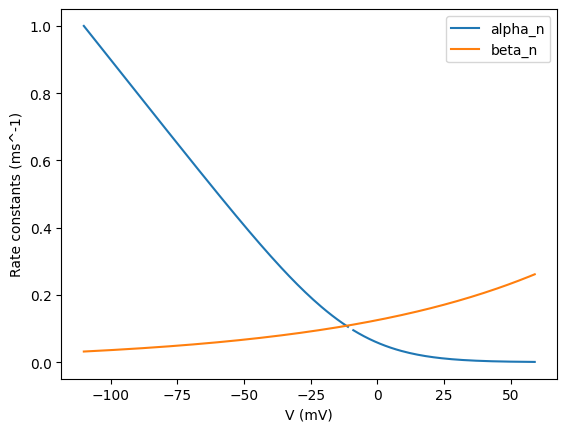

Text(0, 0.5, '$n_\\infty$')

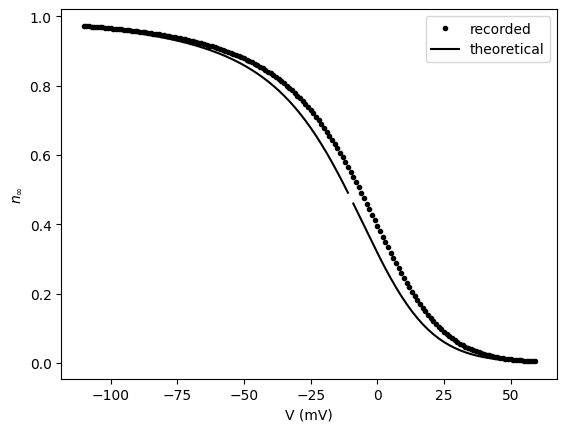

In [ ]:
# Potassium (n) 

ninf = []
voltage_range = np.arange(50, -120, -1)   # scale for recordings
v_range = np.arange(-110, 60)             # original scale

# rate constant formulae according to paper HH: d
alpha_n = 0.01 * (v_range + 10) / (np.exp(v_range / 10 + 1) - 1)
beta_n = 0.125 * np.exp(v_range / 80)
ninf_theoretical = alpha_n / (alpha_n + beta_n)

# go through all voltage levels and record the parameters at each one
for v in voltage_range:

  stim = h.VClamp(mycell.soma(0.5))
  stim.amp[0] = v
  stim.dur[0] = 10 

  tvec = h.Vector().record(h._ref_t)
  vvec = h.Vector().record(mycell.soma(0.5)._ref_v)
  ninf_record = h.Vector().record(mycell.soma(0.5).hh._ref_ninf)

  h.finitialize(v)
  h.continuerun(10)    # run for 10 ms

  # add only the first time step of this voltage level to the final array
  ninf.append(ninf_record[0]) 


# plot rate constants and n_inf
plt.figure()
plt.plot(v_range, alpha_n, label='alpha_n')
plt.plot(v_range, beta_n, label='beta_n')
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('Rate constants (ms^-1)')
plt.show()
plt.plot(v_range, ninf, ".", label="recorded", color="black")
plt.plot(v_range, ninf_theoretical, color="black", label="theoretical")
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('$n_\infty$')

## Sodium Activation

<ipython-input-7-0721fc14aee7>:5: RuntimeWarning: invalid value encountered in true_divide
  alpha_m = 0.1 * (v_range + 25) / (np.exp((v_range +25)/ 10) - 1)


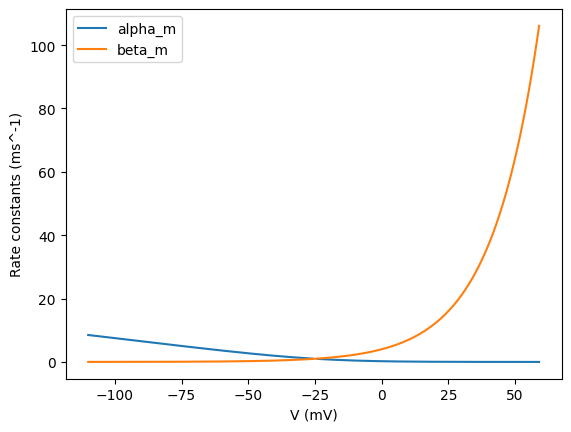

Text(0, 0.5, '$m_\\infty$')

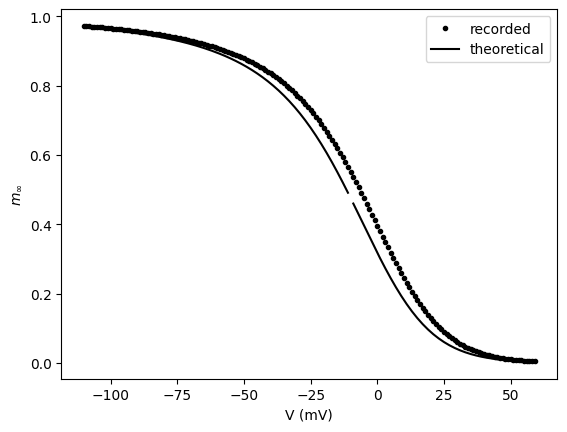

In [ ]:
# sodium activation m
voltage_range = np.arange(50, -120, -1)   # scale for recordings
v_range = np.arange(-110, 60)             # original scale

alpha_m = 0.1 * (v_range + 25) / (np.exp((v_range +25)/ 10) - 1)
beta_m = 4 * np.exp(v_range / 18)
minf_theoretical = alpha_m / (alpha_m + beta_m)

minf = []

for v in voltage_range:

  stim = h.VClamp(mycell.soma(0.5))
  stim.amp[0] = v 
  stim.dur[0] = 10 

  # record time, voltage, m_inf
  tvec = h.Vector().record(h._ref_t)
  vvec = h.Vector().record(mycell.soma(0.5)._ref_v)
  minf_record = h.Vector().record(mycell.soma(0.5).hh._ref_minf)

  h.finitialize(v) 
  h.continuerun(10)

  minf.append(minf_record[0])

#plot figures
plt.plot(v_range, alpha_m, label='alpha_m')
plt.plot(v_range, beta_m, label="beta_m")
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('Rate constants (ms^-1)')
plt.show()
plt.plot(v_range, ninf, ".", label="recorded", color="black")
plt.plot(v_range, ninf_theoretical, color="black", label="theoretical")
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('$m_\infty$')

## Sodium Inactivation

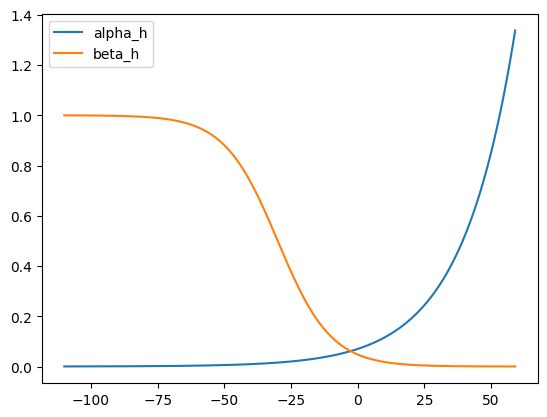

Text(0, 0.5, 'h$_\\infty$')

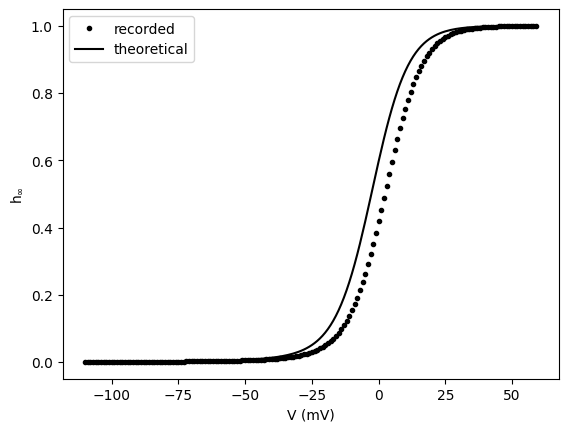

In [ ]:
# h sodium inactivation
voltage_range = np.arange(-110, 60)

# formulea from the original hh paper d
alpha_h = 0.07 * np.exp(voltage_range / 20)
beta_h = 1 / (np.exp((voltage_range + 30) / 10) + 1)
hinf_theoretical = alpha_h / (alpha_h + beta_h)

# plot rate constants
plt.plot(voltage_range, alpha_h, label='alpha_h')
plt.plot(voltage_range, beta_h, label='beta_h')
plt.legend()
plt.show()

# record h_inf at each voltage level
hinf = []
v_range = np.arange(50, -120, -1)
for v in v_range:

  stim = h.VClamp(mycell.soma(0.5))
  stim.amp[0] = v
  stim.dur[0] = 10

  tvec = h.Vector().record(h._ref_t)
  vvec = h.Vector().record(mycell.soma(0.5)._ref_v)
  hinf_record = h.Vector().record(mycell.soma(0.5).hh._ref_hinf)

  h.finitialize(v)
  h.continuerun(10)

  hinf.append(hinf_record[0])

v_range = np.arange(-110, 60)

# plot h_inf
plt.figure()
plt.plot(v_range, hinf, ".", color="black",label="recorded" )
plt.plot(v_range, hinf_theoretical, color="black", label="theoretical")
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel("h$_\infty$")


# Adding Noise

## Conductance Noise

In [ ]:
# Initialization

# Normal
somaA = h.Section('somaA')  # create soma
somaA.insert('hh')          # insert hh ion channels
somaA.pt3dclear()
somaA.pt3dadd(-90,0,0,30)   # specify the section ( from -90 to -60)
somaA.pt3dadd(-60,0,0,30)
somaA.nseg = 1              # number of segments

# Noisy
somaB = h.Section('somaB')
somaB.insert('hh')
somaB.pt3dclear()
somaB.pt3dadd(60,0,0,30)
somaB.pt3dadd(90,0,0,30)
somaB.nseg = 1

In [ ]:
# Record all relevant model values

tvec = h.Vector().record(h._ref_t)
vvecB = h.Vector().record(somaB(0.5)._ref_v)
kvecB = h.Vector().record(somaB(0.5)._ref_ik)
navecB = h.Vector().record(somaB(0.5)._ref_ina)
mvecB = h.Vector().record(somaB(0.5).hh._ref_minf)
nvecB = h.Vector().record(somaB(0.5).hh._ref_n)
hvecB = h.Vector().record(somaB(0.5).hh._ref_h)
gnaB = h.Vector().record(somaB(0.5).hh._ref_gna)


vvecA = h.Vector().record(somaA(0.5)._ref_v)
kvecA = h.Vector().record(somaA(0.5)._ref_ik)
navecA = h.Vector().record(somaA(0.5)._ref_ina)
mvecA = h.Vector().record(somaA(0.5).hh._ref_minf)
nvecA = h.Vector().record(somaA(0.5).hh._ref_n)
hvecA = h.Vector().record(somaA(0.5).hh._ref_h)
gnaA = h.Vector().record(somaA(0.5).hh._ref_gna)

In [ ]:
# Defining the noise

r = h.Random()
noise_std = 0.001
r.normal(0, noise_std)  

# update conductance accoding to formula in noise paper
def modify_conductances():
  somaB(0.5).hh.gna = somaA(0.5).hh.gna + (somaA(0.5).hh.gnabar * r.repick())
  somaB(0.5).hh.gk = somaA(0.5).hh.gk + (somaA(0.5).hh.gkbar * r.repick())

In [ ]:
# Adding stimulus for a spike

stimA = h.IClamp(somaA(0.5))    # clamp for constant current
stimA.delay = 20
stimA.amp = 1
stimA.dur = 10

stimB = h.IClamp(somaB(0.5))
stimB.delay = 20
stimB.amp = 1
stimB.dur = 10

In [ ]:
# Running the simulation in timesteps and changing the conductance at each step

h.finitialize(-60)
cvode = h.CVode()
cvode.active(1)

for i in range(300):
  modify_conductances()
  h.fadvance()

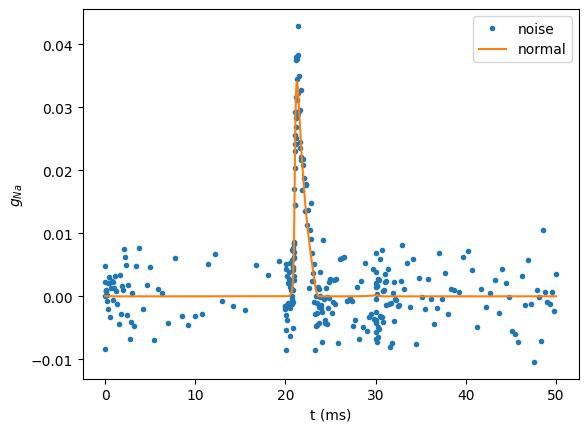

In [ ]:
# Plotting the noise in Sodium Conductance

plt.plot(tvec, gnaB, '.', label="noise")
plt.plot(tvec, gnaA, '-', label="normal")
plt.ylabel("$g_{Na}$")
plt.xlabel("t (ms)")
plt.legend()

Text(0, 0.5, 'current (mA/cm$^2$)')

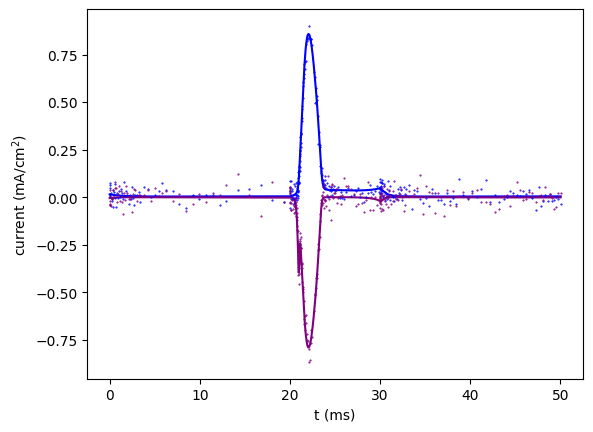

In [ ]:
plt.plot(tvec, kvecB, '-b', label="k_mod")
plt.plot(tvec, navecB, '-', color="purple", label="na_mod")
noise = np.zeros(len(tvec))
noise2 = np.zeros(len(tvec))

for i in range(len(noise)):
  var = np.random.normal(0, 0.03)
  variance2 = np.random.normal(0, 0.04)
  noise[i] = var
  noise2[i] = variance2

noisy_kvecB = kvecB + noise
noisy_navecB = navecB + noise2

#current
plt.plot(tvec, noisy_kvecB, '.b', label="k", markersize=1)
plt.plot(tvec, noisy_navecB, '.', color='purple', label="na", markersize=1)
plt.xlabel('t (ms)')
plt.ylabel('current (mA/cm$^2$)')

In [ ]:
plt.plot(tvec, kvecB, '.markersize='0.5')

## Current Noise

In [ ]:
# Initialization

# Normal
somaA = h.Section('somaA')
somaA.insert('hh')
somaA.pt3dclear()
somaA.pt3dadd(-90,0,0,30)
somaA.pt3dadd(-60,0,0,30)
somaA.nseg = 1

# Noisy
somaB = h.Section('somaB')
somaB.insert('hh')
somaB.pt3dclear()
somaB.pt3dadd(60,0,0,30)
somaB.pt3dadd(90,0,0,30)
somaB.nseg = 1

In [ ]:
# Record all relevant model values

tvec = h.Vector().record(h._ref_t)
vvecB = h.Vector().record(somaB(0.5)._ref_v)
kvecB = h.Vector().record(somaB(0.5)._ref_ik)
navecB = h.Vector().record(somaB(0.5)._ref_ina)
mvecB = h.Vector().record(somaB(0.5).hh._ref_minf)
nvecB = h.Vector().record(somaB(0.5).hh._ref_n)
hvecB = h.Vector().record(somaB(0.5).hh._ref_h)
gnaB = h.Vector().record(somaB(0.5).hh._ref_gna)


vvecA = h.Vector().record(somaA(0.5)._ref_v)
kvecA = h.Vector().record(somaA(0.5)._ref_ik)
navecA = h.Vector().record(somaA(0.5)._ref_ina)
mvecA = h.Vector().record(somaA(0.5).hh._ref_minf)
nvecA = h.Vector().record(somaA(0.5).hh._ref_n)
hvecA = h.Vector().record(somaA(0.5).hh._ref_h)
gnaA = h.Vector().record(somaA(0.5).hh._ref_gna)

In [ ]:
# Add the noise term directly as a current

stim = [None] * 105

for i in range(101):
  stim[i] = h.IClamp(somaB(0.5))
  stim[i].amp = np.random.normal(0, 0.01)
  stim[i].dur = 1
  stim[i].delay = i

In [ ]:
# Run the simulation

h.finitialize(-60)
h.continuerun(100)

0.0

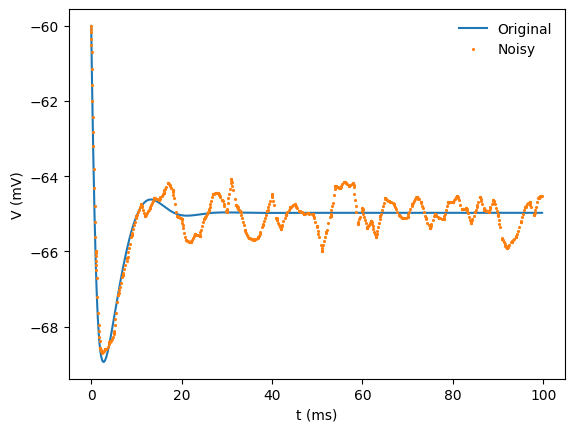

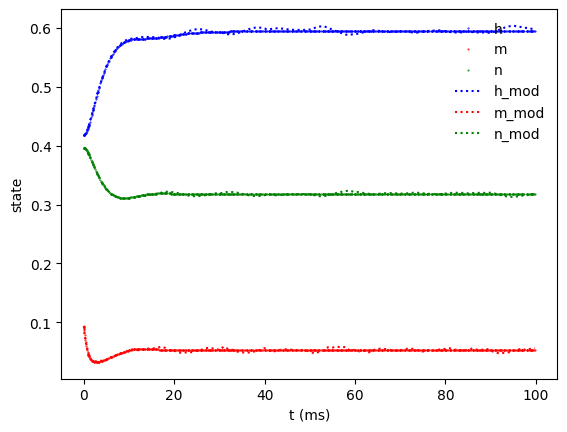

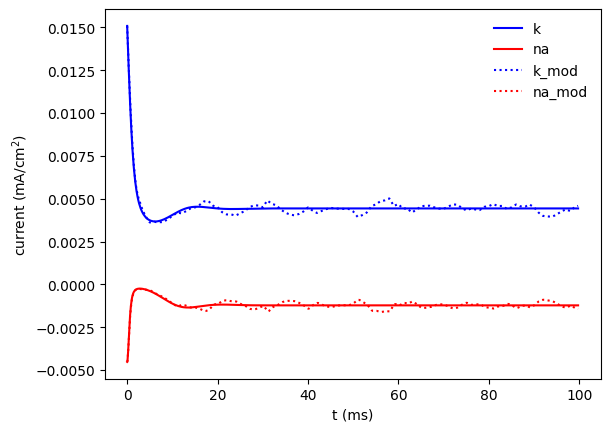

In [ ]:
# Noise in Voltage
fig = plt.figure()
plt.plot(tvec, vvecA, label="Original")
plt.plot(tvec, vvecB, '.', label="Noisy", markersize=2.5)
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')
plt.legend(frameon=False)
plt.show()

# M, H and N values
fig = plt.figure()
plt.plot(tvec, hvecA, '.b', label='h', markersize=0.9)
plt.plot(tvec, mvecA, '.r', label='m', markersize=0.9)
plt.plot(tvec, nvecA, '.g', label='n', markersize=0.9)
plt.plot(tvec, hvecB, ':b', label="h_mod", markersize=0.9)
plt.plot(tvec, mvecB, ':r', label="m_mod", markersize=0.9)
plt.plot(tvec, nvecB, ':g', label="n_mod", markersize=0.9)
plt.xlabel('t (ms)')
plt.ylabel('state')
plt.legend(frameon=False)
plt.show()

# K and Na Current
fig = plt.figure()
plt.plot(tvec, kvecA.as_numpy(), '-b', label='k')
plt.plot(tvec, navecA.as_numpy(), '-r', label='na')
plt.plot(tvec, kvecB, ':b', label="k_mod")
plt.plot(tvec, navecB, ':r', label="na_mod")
plt.xlabel('t (ms)')
plt.ylabel('current (mA/cm$^2$)')
plt.legend(frameon=False)
plt.show()